- 학번 : 201611125
- 이름 : 김정수
- 학과 : 게임전공

## 문제
서울시 열린데이터 https://data.seoul.go.kr/ 에서 제공하는 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv```를 분석해보자.

파일은 웹 검색을 하고 다운로드해서 사용하면 된다.

In [1]:
import pyspark
import os

In [2]:
myConf = pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf = myConf)\
        .getOrCreate()

21/10/10 15:16:22 WARN Utils: Your hostname, jeongxoo.local resolves to a loopback address: 127.0.0.1; using 172.20.10.4 instead (on interface en0)
21/10/10 15:16:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/10 15:16:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### 파일을 읽어서 RDD 생성

In [3]:
myRDD = spark.sparkContext.textFile(os.path.join("data", "서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv"))

In [4]:
df = spark\
        .read\
        .format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true', delimiter=',')\
        .load(os.path.join('data','서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv'))


In [5]:
df.show(5)

+--------+--------+
|대여일자|대여건수|
+--------+--------+
|2018.1.1|    4950|
|2018.1.2|    7136|
|2018.1.3|    7156|
|2018.1.4|    7102|
|2018.1.5|    7705|
+--------+--------+
only showing top 5 rows



In [6]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf

### 문제 1-1: 년도별 대여건수 합계
- 데이터는 2018, 2019년 15개월 간의 대여건수이다. 
- 년도별로 대여건수의 합계를 계산해서 출력하자.


* 정답 예시 :
|year|sum(count)|
|----|----------|
|2018|  10124874|
|2019|   1871935|

In [7]:
def createYear(d):
    return int(d[:4])
createY = udf(createYear, IntegerType())

In [8]:
df = df.withColumn("Year", createY(df['대여일자']))

In [13]:
q1 =  df.groupby(df["Year"]).sum()

In [16]:
q1.select("Year", "Sum(대여건수)").show()

+----+-------------+
|Year|Sum(대여건수)|
+----+-------------+
|2018|     10124874|
|2019|      1871935|
+----+-------------+



### 문제 1-2: 년도별, 월별 대여건수 합계
- 년별, 월별로 대여건수를 계산하여 합계를 계산하여 출력한다.

In [17]:
def createMonth(d):
    d = d.split(".")
    return int(d[1])

createM = udf(createMonth, IntegerType())

In [18]:
df = df.withColumn("Month", createM(df['대여일자']))

In [19]:
q2 = df.groupby(df["Year"], df["Month"]).sum()

In [22]:
q2.show(3)

+----+-----+-------------+---------+----------+
|Year|Month|sum(대여건수)|sum(Year)|sum(Month)|
+----+-----+-------------+---------+----------+
|2018|   10|      1420621|    62558|       310|
|2019|    3|       904819|    62589|        93|
|2018|    1|       164367|    62558|        31|
+----+-----+-------------+---------+----------+
only showing top 3 rows



In [24]:
q3 = q2.sort(q2["Year"], q2["Month"]).select("Year", "Month", "sum(대여건수)")
q3.show()

+----+-----+-------------+
|Year|Month|sum(대여건수)|
+----+-----+-------------+
|2018|    1|       164367|
|2018|    2|       168741|
|2018|    3|       462661|
|2018|    4|       687885|
|2018|    5|       965609|
|2018|    6|      1207123|
|2018|    7|      1100015|
|2018|    8|      1037505|
|2018|    9|      1447993|
|2018|   10|      1420621|
|2018|   11|       961532|
|2018|   12|       500822|
|2019|    1|       495573|
|2019|    2|       471543|
|2019|    3|       904819|
+----+-----+-------------+



### 문제 1-3: 년도별, 월별 대여건수 그래프 
- 문제 1-2의 출력을 선 그래프로 그려보자

In [29]:
g1 = q3.rdd.map(lambda x: [x[0], x[1], x[2]]).collect()

In [52]:
_y = list(map(lambda x: x[2], g1))

In [55]:
y18 = _y[:12]
y19 = _y[12:]

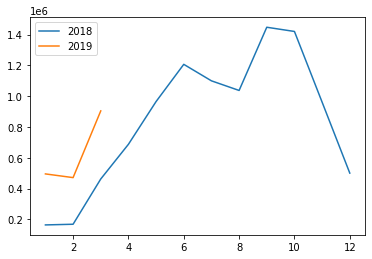

In [63]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,13)], y18, label = "2018")
plt.plot([i for i in range(1,4)], y19, label = "2019")
plt.legend()